## Installing Transformers library

In [ ]:
#Installing transformer package
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00


## Rating Estimation by ChatGPT

In [ ]:
!pip install openai

In [ ]:
import os
import openai
os.environ["OpenAI_API_Key"] = ""
api_key = os.environ.get("OpenAI_API_Key")
openai.api_key = api_key

In [ ]:
# Loss to be added in the custom loss
def get_chatgpt_rating(prompt, sample):
  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user",
     "content": f"{prompt} {sample}"}
  ])
  return 10 - int(completion.choices[0].message)

In [ ]:
# Different prompts tested in order to generate a sensible rating
prompt1 = "Provide me rating between 0 and 10 (without any explanation), where 0 is the best and 10 is the worst, for the following story summary: "
prompt2 = "Assign a rating between 0 (best) and 10 (worst) to the given artificial story summary (only give rating as the response):"
prompt3 = "Assign a rating between 0 (best) and 10 (worst) to the given artificial story summary (only give rating as the response). The rating should be based on writing style, coherence and capture strength. Summary:"
prompt4 = "Assign a rating between 0 and 10 to the given artificial story summary. Only give rating as the response (no reasoning). The rating should be based on writing style, coherence, and capture strength. Summary:" # Best
prompt5 = "Provide me rating between 0 and 10 (without any explanation),  for the following story summary:"

## Data Tokenization/Encoding

In [ ]:
#Loading the standard T5 small model and tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# Can try different T5 models such as T5-large, T5-3B, T5-11B
base_tokenizer = AutoTokenizer.from_pretrained('t5-small')
base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
# Encoding the sequences
def encode_sequences(x, base_tokenizer = base_tokenizer):
  # try:
    # Input consists of different aspects of the story on which the output will be conditioned
    input = x['Input']
    # Label is the conditioned output - Story
    label = x['Summary']
    # Max length of the input sequence in T5 is 512 tokens (BART could be used for longer sequences - 1024 max length limit)
    model_input = base_tokenizer(input, max_length = 512, truncation=True, padding='max_length')
    model_input['labels'] = base_tokenizer(label, max_length = 512, truncation=True, padding='max_length')['input_ids']
    return model_input

In [ ]:
# Loading the final dataset
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Training_Dataset')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)

In [ ]:
# Tokenizing the dataset
train_df = train_df.apply(encode_sequences, axis=1)
test_df = test_df.apply(encode_sequences, axis = 1)

In [ ]:
train_df.dropna(inplace = True)
test_df.dropna(inplace = True)

In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

## Number of parameters

In [ ]:
# p is accessing each layer's weight tensors of the model
# p.requires_grad() checks whether the layer is frozen for training or not
# p.numel returns total number of elements in the weight tensor - total number of parameters
print("Parameters:", sum(p.numel() for p in base_model.parameters() if p.requires_grad))

Parameters: 60506624


## Accessing different layers of a Model

In [ ]:
base_model

In [ ]:
# We access each layer by the key. That is to access (x), we use base_model.x
# Try and go layer by layer. First check the output of a.b, then go for a.b.c
layer_id = 0
base_model.encoder.block[layer_id].layer[0].SelfAttention.o

Linear(in_features=512, out_features=512, bias=False)

In [ ]:
base_model.encoder.block[layer_id].layer[1].DenseReluDense.wo

Linear(in_features=2048, out_features=512, bias=False)

In [ ]:
base_model.decoder.block[layer_id].layer[0].SelfAttention.o

Linear(in_features=512, out_features=512, bias=False)

In [ ]:
base_model.decoder.block[layer_id].layer[2].DenseReluDense.wo

Linear(in_features=2048, out_features=512, bias=False)

## T5 w Adapters

Could also utilize [adapter-transformers](https://github.com/adapter-hub/adapter-transformers) library - provides easy abstract way of incorporating adapters in the models

In [ ]:
# Freeze all layers
for param in base_model.parameters():
    param.requires_grad = False

In [ ]:
# Function to countnumber of trainable paramters in a layer/block
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import torch
# Creating a custom Adapter layer
def make_adapter(in_dim, bottleneck_dim, out_dim):
    adapter_layers = torch.nn.Sequential(
        torch.nn.Linear(in_dim, bottleneck_dim),
        torch.nn.GELU(),
        torch.nn.Linear(bottleneck_dim, out_dim),
    )
    return adapter_layers

Due to the forward pass code of DenseReluDense, we cannot add adpaters as a Sequential block in the Feed forward layer

In [ ]:
total_size = 0
bottleneck_size = 32 # hyperparameter

for layer_id in range(6):

    #############################################################
    # insert 1st adapter layer into transformer block in Encoder
    #############################################################

    orig_layer_1 = base_model.encoder.block[layer_id].layer[0].SelfAttention.o

    adapter_layers_1 = make_adapter(
        in_dim=orig_layer_1.out_features,
        bottleneck_dim=bottleneck_size,
        out_dim=orig_layer_1.out_features)

    new_1 = torch.nn.Sequential(orig_layer_1, *adapter_layers_1)
    base_model.encoder.block[layer_id].layer[0].SelfAttention.o = new_1

    total_size += count_parameters(adapter_layers_1)

    #############################################################
    # insert 1st adapter layer into transformer block in Decoder
    #############################################################

    orig_layer_1 = base_model.decoder.block[layer_id].layer[0].SelfAttention.o

    adapter_layers_1 = make_adapter(
        in_dim=orig_layer_1.out_features,
        bottleneck_dim=bottleneck_size,
        out_dim=orig_layer_1.out_features)

    new_1 = torch.nn.Sequential(orig_layer_1, *adapter_layers_1)
    base_model.decoder.block[layer_id].layer[0].SelfAttention.o = new_1

    total_size += count_parameters(adapter_layers_1)

print("Number of adapter parameters added:", total_size)

Number of adapter parameters added: 399744


## T5 w LoRA

In [ ]:
# Installing PEFT Library
!pip install peft

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 20.8 MB/s eta 0:00:00


In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# We are usig LoRA for parameter efficient fine tuning of a Seq2SeqLM. Arguments' default values are taken from the demonstrations
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

In [ ]:
# Customizing the model foe peft
model = get_peft_model(base_model, peft_config)
# Number of trainable parameters in the model in PEFT model
model.print_trainable_parameters()

trainable params: 294912 || all params: 60801536 || trainable%: 0.4850403779272945


## T5 Training Setup (Includes Custom Loss Function)

In [ ]:
# Initializing the Data Collator for batching of the dataset
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(
        tokenizer=base_tokenizer,
        return_tensors="pt",
        max_length = 512,
        padding = 'max_length',
        model = base_model
    )

In [ ]:
!pip install accelerate

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Path where model training loss and intermediate weights will be stored
"""
Change model path to
1) /content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/Basic - when using no pEDT methods
2) /content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/Adapters - when using Adapters
3) /content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/LoRA - when using LoRA
"""
model_path = f'/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model'


#Specifying the training argument
training_args = Seq2SeqTrainingArguments(
    output_dir=model_path,
    per_device_train_batch_size=2,
    overwrite_output_dir = True,
    evaluation_strategy="no",
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    fp16=True
)

In [ ]:
# Overwrite the Trainer API for utilizing custom loss function
import torch
import torch.nn.functional as F
class CustomSeq2SeqTrainer(Seq2SeqTrainer):
  def compute_loss(self, model, inputs, return_outputs=False):
      labels = inputs.pop("labels")
      input_ids = inputs.pop("input_ids")
      attention_mask = inputs.pop("attention_mask")
      outputs = model(input_ids = input_ids, labels = labels, attention_mask = attention_mask)
      loss_cross_entropy = outputs.loss
      logits = outputs.logits
      loss_GPT = custom_loss_function(logits)
      loss = (loss_cross_entropy + torch.tensor(loss_GPT))
      return (loss, outputs) if return_outputs else loss

# Check whether the tokenizer is being passed as an argument
def custom_loss_function(logits, tokenizer=base_tokenizer):
    loss_GPT = 10
    summaries = base_tokenizer.batch_decode(F.softmax(logits, dim=-1).argmax(dim=-1), skip_special_tokens=True)
    for summary in summaries:
      loss_GPT = loss_GPT + (10 - int(get_chatgpt_rating(prompt4, summary)))
    return loss_GPT


In [ ]:
# Initializing the trainer

trainer = Seq2SeqTrainer(
    model=base_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=train_df,       # training dataset
    eval_dataset = test_df,
)

In [ ]:
#Custom Trainer function using Customized Loss function

trainer = CustomSeq2SeqTrainer(
    model=base_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=train_df,       # training dataset
    eval_dataset = test_df,
)

## Model Training

In [ ]:
# Starting the training
trainer.train()

In [ ]:
# Saving the final model
trainer.save_model()

## Model Evaluation

In [ ]:
trainer.evaluate()

## Loading and Testing of the FT model

In [ ]:
"""
Change model path to
1) /content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/Basic - when using no pEDT methods
2) /content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/Adapters - when using Adapters
3) /content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/LoRA - when using LoRA
"""
model_path = f'/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model'

base_tokenizer = AutoTokenizer.from_pretrained(model_path)
base_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

## Model Eval (BLEU)

In [ ]:
!pip install evaluate

In [ ]:
from evaluate import load
#Loading the BLEU score metric
bleu = load("bleu")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Training_Dataset')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Training_Dataset')

In [ ]:
def encode_input(x, base_tokenizer = tokenizer):
  x = str(x)
  return base_tokenizer(x, max_length = 512, truncation=True, padding='max_length')

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Training_Dataset')
train_df, test_df = train_test_split(df, test_size=0.1. random_state=1)
test_df['Input'] = test_df['Input'].apply(encode_input)

In [ ]:
from transformers import pipeline
#creating pipeline for FT model
generator = pipeline(model=model, tokenizer = tokenizer)

In [ ]:
num_beams = 1
top_p = 1.0
do_sample = False
#Greedy, Ancestral and Nucleus
decoding_strats = [[1,1.0, False],[1,1.0, True],[1,0.9, True]]

In [ ]:
#BLEU score eval of FT model
results = []
predictions = []
references = []
for x in decoding_strats:
  num_beams, top_p, do_sample = x
  for idx in test_df.iterrows():
    references.append(test_df['Summary'].iloc[idx])
    predictions.append(generator(str(test_df['Input'].iloc[idx]), num_beams = num_beams, top_p = top_p, do_sample = do_sample, max_length = 150)[0]['generated_text'])
  base_results = bleu.compute(predictions=predictions, references=references)
  results.append(base_results)
print(results)

## Loss curve

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

In [8]:
# List of different configurations of T5 model
models = ['Basic','Adapters','LoRA']

In [4]:
#Abstraction of the loss and epochs from the log history
def get_epoch(x):
  return x['epoch']

def get_loss(x):
  return x['loss']

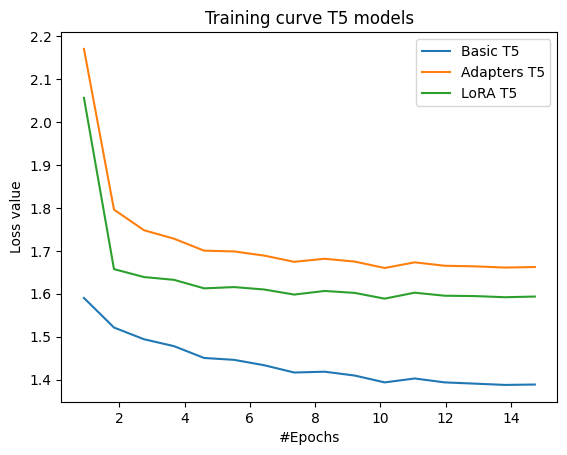

In [12]:
for i in models:
  #Loading the trainer_state json file, which consists of the losses at different steps/epochs
  df = pd.read_json(f'/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/{i}/checkpoint-8000/trainer_state.json')
  #Organize in a way to extract losses and steps
  df['epoch_number'] = df['log_history'].apply(get_epoch)
  df ['loss'] = df['log_history'].apply(get_loss)
  #Plotting of the training loss curve for the FT Model
  plt.plot(df['epoch_number'].values, df['loss'].values, label = f"{i} T5")
plt.xlabel('#Epochs')
plt.ylabel('Loss value')
plt.title('Training curve T5 models')
plt.legend()
plt.show()